# MNIST Classification: Comparing Random Forest, Neural Network, and CNN

This notebook explores the **MNIST dataset**, which consists of handwritten digit images (0-9).  

In [94]:
from abc import ABC, abstractmethod

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, random_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import os

## Define the `MnistClassifierInterface`

In [ ]:
class MnistClassifierInterface(ABC):
    """Interface for MNIST classifiers"""
    @abstractmethod
    def train(self, train_loader, epochs=1, val_loader=None):
        pass
    
    @abstractmethod
    def predict(self, X):
        pass

## Data Loading and Preprocessing

In [96]:
# Define transformations to normalize data
# Mean and std for MNIST dataset obtained from:
# https://stackoverflow.com/questions/63746182/correct-way-of-normalizing-and-scaling-the-mnist-dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and std for MNIST dataset
])

In [97]:
# Download and create MNIST dataset
dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

In [98]:
# The MNIST dataset comprises 60,000 training images and 10,000 test images.
# Split the dataset: 50,000 for training and 10,000 for validation.
# This standard split is widely adopted in the machine learning community for benchmarking purposes.
train_dataset, val_dataset = random_split(dataset, [50000, 10000])

In [99]:
# Also prepare a test dataset 
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [100]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Visualize some images from the dataset.

In [101]:
def visualize_mnist(dataset, num_images=25, nrows=5, ncols=5, 
                    mean=0.0, std=1.0, shuffle=False):
    """
    Visualize images from the MNIST dataset.
    
    Parameters:
    - dataset: The MNIST dataset object
    - num_images: Number of images to display (default 25)
    - nrows: Number of rows in grid (default 5)
    - ncols: Number of columns in grid (default 5)
    - mean: Mean used in normalization (default 0.0)
    - std: Standard deviation used in normalization (default 1.0)
    - shuffle: Whether to show random images (default False)
    """
    # Ensure we don't request more images than available
    num_images = min(num_images, len(dataset))
    
    # Create figure and axes
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    axes = axes.flatten()  # Convert to 1D array for easier iteration
    
    # Get indices to show
    if shuffle:
        indices = np.random.choice(len(dataset), num_images, replace=False)
    else:
        indices = range(num_images)
    
    # Plot images
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        
        # Convert tensor to numpy array and denormalize
        img = img.numpy().squeeze()  # Remove channel dimension
        img = (img * std) + mean     # Reverse normalization
        img = np.clip(img, 0, 1)     # Ensure valid pixel values
        
        # Plot image
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    # Hide any unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

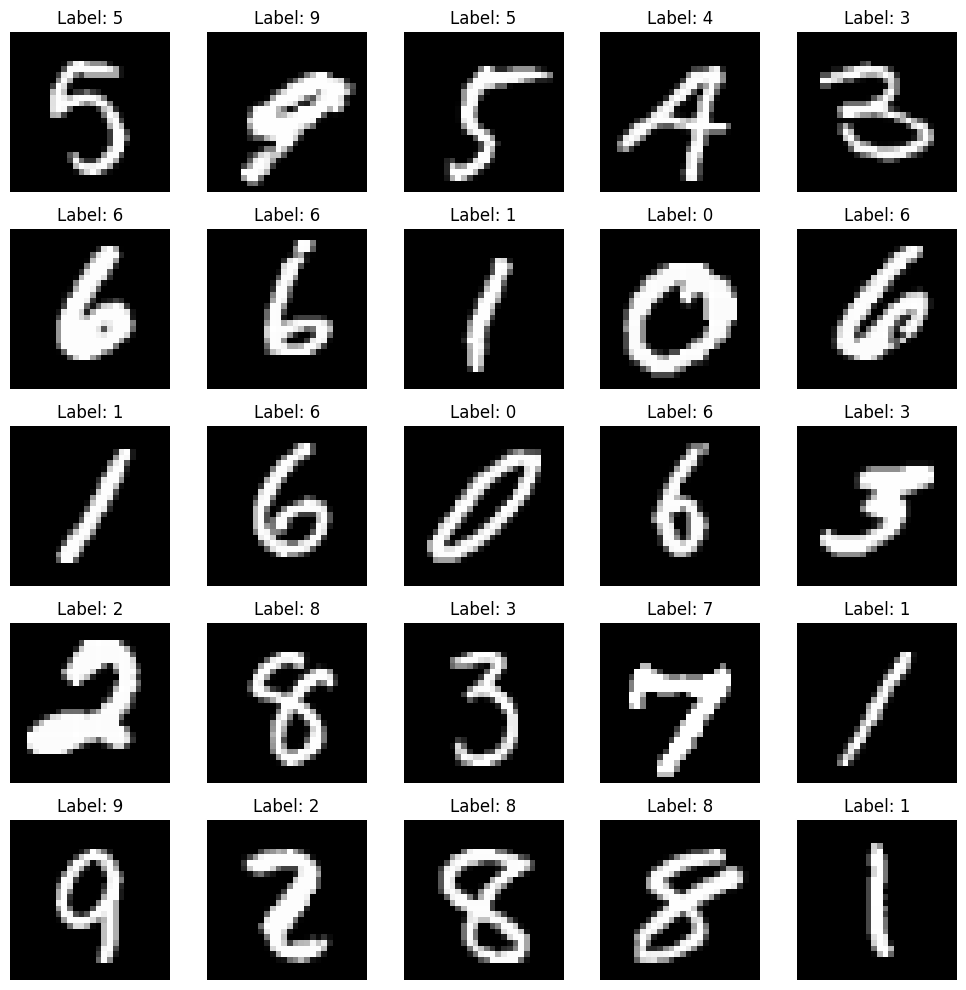

In [102]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # Workaround for OpenMP conflict
visualize_mnist(train_dataset, mean=0.1307, std=0.3081, shuffle=True)

## Implementing the Concrete Classifiers

### Random Forest Classifier

Since we have both a training and validation set, I will concatenate them to create a larger training dataset for the Random Forest (RF) model. To ensure robust model evaluation and hyperparameter tuning, I will use k-fold cross-validation. Given that the dataset is quite large (60,000 samples), I will set a smaller value for the cross-validation parameter (cv) to reduce computational cost while still achieving a reliable evaluation.

In [ ]:
class RandomForestMnistClassifier(MnistClassifierInterface):
    """
    Implements a Random Forest for MNIST classification using combined train+val data and cross-validation.
    """
    def __init__(self, n_estimators=100):
        super().__init__()
        self.model = RandomForestClassifier(n_estimators=n_estimators)
        self.is_trained = False

    def train(self, train_loader, epochs=1, val_loader=None):
        # Concatenate train and validation data
        X_train, y_train = self._collect_data([train_loader, val_loader])
        
        # Perform cross-validation
        cv_scores = cross_val_score(self.model, X_train, y_train, cv=5)
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

        # Train final model on full dataset
        self.model.fit(X_train, y_train)
        self.is_trained = True
        print("Random Forest trained with cross-validation!")

    def _collect_data(self, loaders):
        X, y = [], []
        for loader in loaders:
            if loader: # Ensure loader is not None
                for images, labels in loader:
                    batch_size = images.shape[0]
                    X.append(images.view(batch_size, -1).numpy())
                    y.append(labels.numpy())
        return np.concatenate(X), np.concatenate(y) # Merge batches into a single dataset

    def predict(self, X):
        if not self.is_trained:
            raise RuntimeError("Model not trained")
        return self.model.predict(X.view(X.size(0), -1).numpy()) # Flatten and convert input before prediction

### Feed-Foward Neural Network

In [ ]:
class FeedForwardMnistClassifier(MnistClassifierInterface):
    """
    Implements a Feed-Forward Neural Network for MNIST classification with train/val metrics.
    784 -> 256 -> 10 architecture with ReLU activation.
    """
    def __init__(self, lr=0.001):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.is_trained = False

    def train(self, train_loader, epochs=1, val_loader=None):
        self.model.train()
        for epoch in range(epochs):
            # Training phase
            train_loss, train_acc = self._run_epoch(train_loader, training=True)
            
            # Validation phase (if provided)
            if val_loader:
                val_loss, val_acc = self._run_epoch(val_loader, training=False)
                print(f"Epoch [{epoch+1}/{epochs}] - "
                    f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            else:
                print(f"Epoch [{epoch+1}/{epochs}] - "
                    f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                
        self.is_trained = True
        print("Feed-Forward NN trained!")

    def _run_epoch(self, loader, training=True):
        loss_total = 0.0
        correct = 0
        total = 0
        
        for images, labels in loader:
            # Reshape images from (batch_size, 1, 28, 28) to (batch_size, 784) for the linear layer
            images = images.view(images.size(0), -1)
            
            if training:
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
            else:
                # Disable gradient computation during validation (reduces memory usage & improves speed)
                with torch.no_grad():
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)

            # Get the predicted class by taking the max logit (highest probability)
            _, preds = torch.max(outputs, 1) 
            loss_total += loss.item() * images.size(0)
            correct += (preds == labels).sum().item()
            total += images.size(0)

        return loss_total / total, correct / total 

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            return self.model(X.view(X.size(0), -1)).argmax(dim=1) # Get class with highest probability

### Convolutional Neural Network

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(32*7*7, 10)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class ConvolutionalMnistClassifier(MnistClassifierInterface):
    """
    Implements a CNN for MNIST classification with train/val metrics.
    """
    def __init__(self, lr=0.001):
        super().__init__()
        self.model = ConvNet()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.is_trained = False

    def train(self, train_loader, epochs=1, val_loader=None):
        self.model.train()
        for epoch in range(epochs):
            # Training phase
            train_loss, train_acc = self._run_epoch(train_loader, training=True)

            # Validation phase (if provided)
            if val_loader:
                val_loss, val_acc = self._run_epoch(val_loader, training=False)
                print(f"Epoch [{epoch+1}/{epochs}] - "
                    f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            else:
                print(f"Epoch [{epoch+1}/{epochs}] - "
                    f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                
        self.is_trained = True
        print("CNN trained!")

    def _run_epoch(self, loader, training=True):
        loss_total = 0.0
        correct = 0
        total = 0
        
        for images, labels in loader:
            if training:
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
            else:
                # Disable gradient computation for validation (faster and saves memory)
                with torch.no_grad():
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)

            # Get predicted class from output logits
            _, preds = torch.max(outputs, 1)
            loss_total += loss.item() * images.size(0)
            correct += (preds == labels).sum().item()
            total += images.size(0)

        return loss_total / total, correct / total

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            return self.model(X).argmax(dim=1) # Return class with highest probability

## The `MnistClassifier` Facade

Finally, we create a class that hides the underlying classifier. Its constructor takes an `algorithm` parameter (`"rf"`, `"nn"`, or `"cnn"`) and internally initializes the corresponding classifier object.

In [106]:
class MnistClassifier:
    """
    Facade for MNIST classifiers with updated training logic.
    """
    def __init__(self, algorithm="cnn"):
        if algorithm == "rf":
            self.classifier = RandomForestMnistClassifier()
        elif algorithm == "nn":
            self.classifier = FeedForwardMnistClassifier()
        elif algorithm == "cnn":
            self.classifier = ConvolutionalMnistClassifier()
        else:
            raise ValueError("Invalid algorithm")

    def train(self, train_loader, epochs=1, val_loader=None):
        self.classifier.train(train_loader, epochs, val_loader)

    def predict(self, X):
        return self.classifier.predict(X)

## Demonstration of the `MnistClassifier` using the three algorithms

In [ ]:
# Function to evaluate classifier on a dataset
def evaluate(classifier, loader):
    correct = 0
    total = 0
    for images, labels in loader:
        preds = classifier.predict(images) 
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total

### Training the Random Forest Classifier

In [108]:
rf_classifier = MnistClassifier('rf')
rf_classifier.train(train_loader, val_loader=val_loader)
print("Random Forest Test Accuracy:", evaluate(rf_classifier, test_loader))

Cross-validation scores: [0.96791667 0.96458333 0.97033333 0.968      0.96591667]
Mean CV accuracy: 0.9674 ± 0.0020
Random Forest trained with cross-validation!
Random Forest Test Accuracy: 0.9694


### Training the Feed-Forward Neural Network

In [111]:
nn_classifier = MnistClassifier('nn')
nn_classifier.train(train_loader, epochs=5, val_loader=val_loader)
print("Feed-Forward NN Test Accuracy:", evaluate(nn_classifier, test_loader))

Epoch [1/5] - Train Loss: 0.2176, Train Acc: 0.9335 | Val Loss: 0.1232, Val Acc: 0.9638
Epoch [2/5] - Train Loss: 0.0952, Train Acc: 0.9710 | Val Loss: 0.0888, Val Acc: 0.9730
Epoch [3/5] - Train Loss: 0.0647, Train Acc: 0.9795 | Val Loss: 0.0939, Val Acc: 0.9734
Epoch [4/5] - Train Loss: 0.0490, Train Acc: 0.9842 | Val Loss: 0.0946, Val Acc: 0.9744
Epoch [5/5] - Train Loss: 0.0383, Train Acc: 0.9876 | Val Loss: 0.0929, Val Acc: 0.9741
Feed-Forward NN trained!
Feed-Forward NN Test Accuracy: 0.9718


### Training the Convolutional Neural Network

In [110]:
cnn_classifier = MnistClassifier('cnn')
cnn_classifier.train(train_loader, epochs=5, val_loader=val_loader)
print("CNN Test Accuracy:", evaluate(cnn_classifier, test_loader))

Epoch [1/5] - Train Loss: 0.1502, Train Acc: 0.9546 | Val Loss: 0.0653, Val Acc: 0.9794
Epoch [2/5] - Train Loss: 0.0553, Train Acc: 0.9828 | Val Loss: 0.0559, Val Acc: 0.9830
Epoch [3/5] - Train Loss: 0.0400, Train Acc: 0.9879 | Val Loss: 0.0576, Val Acc: 0.9823
Epoch [4/5] - Train Loss: 0.0319, Train Acc: 0.9901 | Val Loss: 0.0391, Val Acc: 0.9883
Epoch [5/5] - Train Loss: 0.0250, Train Acc: 0.9919 | Val Loss: 0.0397, Val Acc: 0.9870
CNN trained!
CNN Test Accuracy: 0.9897


## Conclusion

The implemented models—Random Forest, Feed-Forward Neural Network, and Convolutional Neural Network—achieved high classification accuracy on the MNIST dataset, with CNN performing the best at 98.97% test accuracy. The structured approach using object-oriented programming ensures modularity and flexibility, allowing seamless selection and evaluation of different classification algorithms.